# Importing of libraries

In [1]:
import pandas as pd
import seaborn as sns
import datetime as datetime
import re
import numpy as np
import statsmodels.api as sm
import pandas_ta as ta
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score
from pandas.tseries.offsets import BDay
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot

# Defining functions

In [2]:
def clean_tweet(tweet):
    """ Utility function to clean tweet text by removing links, special characters using simple regex statements. """
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+://\S+)", " ", tweet).split())

# Return the polarity of the tweet using TextBlob analysis
def analyse_tweet(tweet):
    """ Utility function to classify sentiment of passed tweet using textblob's sentiment method """
    clean_tweet(tweet)
    # create TextBlob object of passed tweet text
    tweet_analysis = TextBlob(tweet)
    return tweet_analysis.sentiment.polarity

# Analyse tweet using TextBlob and categorize it as 'positive', 'negative' or 'neutral'
def get_tweet_sentiment(tweet):
    tweet_polarity = analyse_tweet(tweet)
    # set sentiment
    if tweet_polarity > 0:
        return 'positive'
    elif tweet_polarity == 0:
        return 'neutral'
    else:
        return 'negative'

def filter_by_daterange(df):
    start_date = pd.to_datetime("2011-1-3").date()
    end_date = pd.to_datetime("2021-03-01").date()
    mask = (df['Time'] > start_date) & (df['Time'] <= end_date)
    df = df.loc[mask]
    #Filter only Business day
    isBusinessDay = BDay().onOffset
    match_series = pd.to_datetime(df['Time']).map(isBusinessDay)
    df[match_series]
    return df

def clean_tweet_data(tweets):
    # Convert 'Time' column to datetime and strip time information.
    tweets['Time'] = pd.to_datetime(tweets['Time']).dt.date
    # Consider only dates between a range
    tweets = filter_by_daterange(tweets)
    # Add sentiment of the tweet to the data.
    tweets['Sentiment'] = tweets.apply(lambda row : get_tweet_sentiment(row['Tweet']), axis=1)
    tweets_sentiment = tweets[['Time', 'Sentiment']].copy() 
    # Will consider maximum tweet sentiment as the sentiment of the day.
    tweets_sentiment = tweets_sentiment.groupby(tweets_sentiment.Time)\
                        .agg(lambda x: x.value_counts().index[0])
    tweets_sentiment.sort_values(by=['Time'], inplace=True)
    return tweets_sentiment

def clean_stock_data(stock_data):
    #Remove null stock data.
    stock_data = stock_data.dropna()
    #Convert 'Date' column to datetime and strip time information.
    stock_data['Time'] = pd.to_datetime(stock_data['Date']).dt.date
    stock_data = stock_data.drop('Date',1)
    #Consider only dates between a range
    stock_data = filter_by_daterange(stock_data)    
    #Calculate daily change percentage
    stock_data['daily_percentage_change'] = (stock_data['Close'] - stock_data['Open']) / stock_data['Open'] * 100
    stock_daily_change = stock_data[['Time', 'daily_percentage_change']].copy()
    stock_daily_change.sort_values(by=['Time'], inplace=True)
    return stock_daily_change

def merge_tweets_and_stock_data(tweets_sentiment_data, stock_price_change_data):
    #Combine two dataframes based on time.
    sentiment_stock_change_data = pd.merge(tweets_sentiment_data, stock_price_change_data, on='Time', how='inner')
    return sentiment_stock_change_data

def make_sentiment_column_categorical(tweet_sentiment_with_price_change):
    #Change 'Sentiment' column to categorical column.
    tweet_sentiment_with_price_change['Sentiment'] = tweet_sentiment_with_price_change['Sentiment'].astype('category')
    tweet_sentiment_with_price_change['Sentiment'] = tweet_sentiment_with_price_change['Sentiment'].cat.codes
    return tweet_sentiment_with_price_change

def linear_regression_data():
    X=df[["negative", "positive", "%_delta_Nasdaq", "EMA_10"]]
    Y=df[["%_delta_Tesla"]]
    return X,Y

def logistic_regression_data():
    X=df[["negative", "positive", "%_delta_Nasdaq", "EMA_10"]]
    Y=df[["Binary_delta_Tesla"]]
    return X,Y

def check_linearity_assumption(ax, fitted_y, residuals):
    sns.residplot(
        x=fitted_y,
        y=residuals,
        lowess=True,
        scatter_kws={"alpha": 0.5},
        line_kws={"color": "red", "lw": 1, "alpha": 0.8},
        ax=ax,
    )
    ax.set_title("Residuals vs Fitted")
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals")


def check_residual_normality(ax, residuals_normalized):
    qq = ProbPlot(residuals_normalized)
    qq.qqplot(line="45", alpha=0.5, lw=1, ax=ax)
    ax.set_title("Normal Q-Q")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Standardized Residuals")


def check_homoscedacticity(ax, fitted_y, residuals_norm_abs_sqrt):
    plot_3 = plt.figure()
    ax.scatter(fitted_y, residuals_norm_abs_sqrt, alpha=0.5)
    sns.regplot(
        x=fitted_y,
        y=residuals_norm_abs_sqrt,
        scatter=False,
        ci=False,
        lowess=True,
        line_kws={"color": "red", "lw": 1, "alpha": 0.8},
        ax=ax,
    )
    ax.set_title("Scale-Location")
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("$\\sqrt{|Standardized Residuals|}$")


def check_influcence(ax, leverage, cooks, residuals_normalized):
    ax.scatter(leverage, residuals_normalized, alpha=0.5)
    sns.regplot(
        x=leverage,
        y=residuals_normalized,
        scatter=False,
        ci=False,
        lowess=True,
        line_kws={"color": "red", "lw": 1, "alpha": 0.8},
        ax=ax,
    )
    ax.set_xlim(0, max(leverage) + 0.01)
    ax.set_ylim(-3, 5)
    ax.set_title("Residuals vs Leverage")
    ax.set_xlabel("Leverage")
    ax.set_ylabel("Standardized Residuals")


def summary_plots(lm, title=""):
    fitted_y = lm.fittedvalues
    residuals = lm.resid
    residuals_normalized = lm.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(residuals_normalized))
    leverage = lm.get_influence().hat_matrix_diag
    cooks = lm.get_influence().cooks_distance[0]

    fig, axs = plt.subplots(2, 2)
    check_linearity_assumption(axs[0, 0], fitted_y, residuals)
    check_residual_normality(axs[0, 1], residuals_normalized)
    check_homoscedacticity(axs[1, 0], fitted_y, model_norm_residuals_abs_sqrt)
    check_influcence(axs[1, 1], leverage, cooks, residuals_normalized)

    fig.suptitle(title)

    plt.show()

# Importing files

### Elon Musk's tweets

In [3]:
tweets_df = pd.read_csv("2021.csv", encoding='latin1')
tweets_df=tweets_df.rename(columns={'date':'Time'})
tweets_df=tweets_df.rename(columns={'tweet':'Tweet'})

### Tesla stock price

In [4]:
tesla_stock_price_df = pd.read_csv("TSLA.csv")

### Nasdaq index price

In [5]:
nsdq=pd.read_csv("^IXIC.csv")
nsdq=nsdq.rename(columns={'Time':'Date'})

# Preprocessing

### Cleaning the data

In [6]:
cleaned_tweets_with_sentiment = clean_tweet_data(tweets_df)
tesla_stock_with_daily_change = clean_stock_data(tesla_stock_price_df)
nsdq_daily_change=clean_stock_data(nsdq)

C:\Users\rrusa\anaconda3\lib\site-packages\pandas\core\base.py:870: FutureWarning: onOffset is a deprecated, use is_on_offset instead
  new_values = map_f(values, mapper)
C:\Users\rrusa\AppData\Local\Temp/ipykernel_22132/3014869824.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['Sentiment'] = tweets.apply(lambda row : get_tweet_sentiment(row['Tweet']), axis=1)
C:\Users\rrusa\AppData\Local\Temp/ipykernel_22132/3014869824.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  stock_data = stock_data.drop('Date',1)


### Merging the data

In [7]:
df = merge_tweets_and_stock_data(cleaned_tweets_with_sentiment, tesla_stock_with_daily_change)
df = df.merge(nsdq_daily_change,on='Time')
dummies = pd.get_dummies(df["Sentiment"])
df=dummies.join(df)

### Renaming columns

In [8]:
df=df.rename(columns={0:'Negative'})
df=df.rename(columns={1:'Neutral'})
df=df.rename(columns={2:'Positive'})
df=df.rename(columns={'daily_percentage_change_x':'%_delta_Tesla'})
df=df.rename(columns={'daily_percentage_change_y':'%_delta_Nasdaq'})

### Adding exponential moving average

In [9]:
df.ta.ema(close='%_delta_Tesla', length=10, append=True)
df = df.dropna()

# Explanatory analysis

### Paring sentiment against the Tesla stock price change

<AxesSubplot:xlabel='Sentiment', ylabel='%_delta_Tesla'>

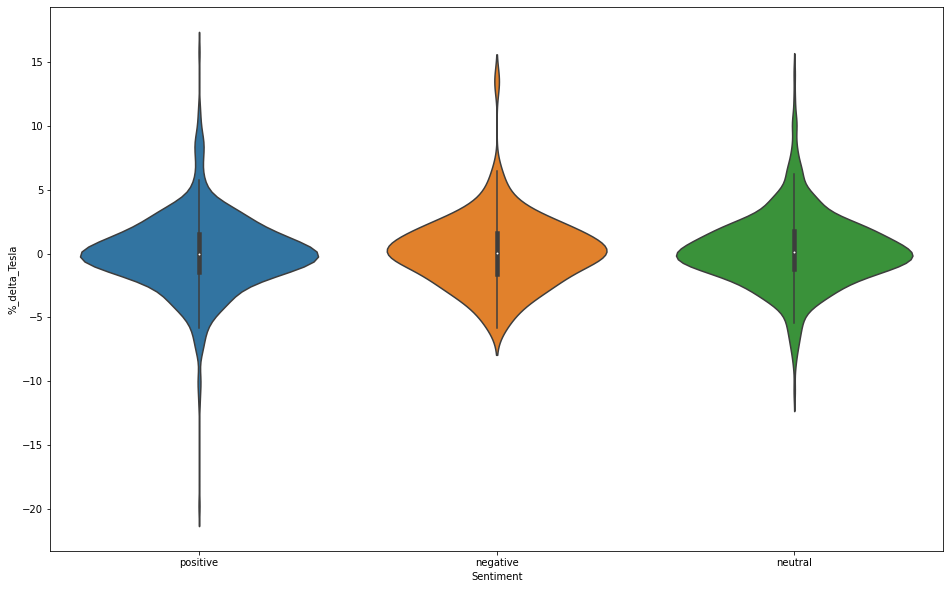

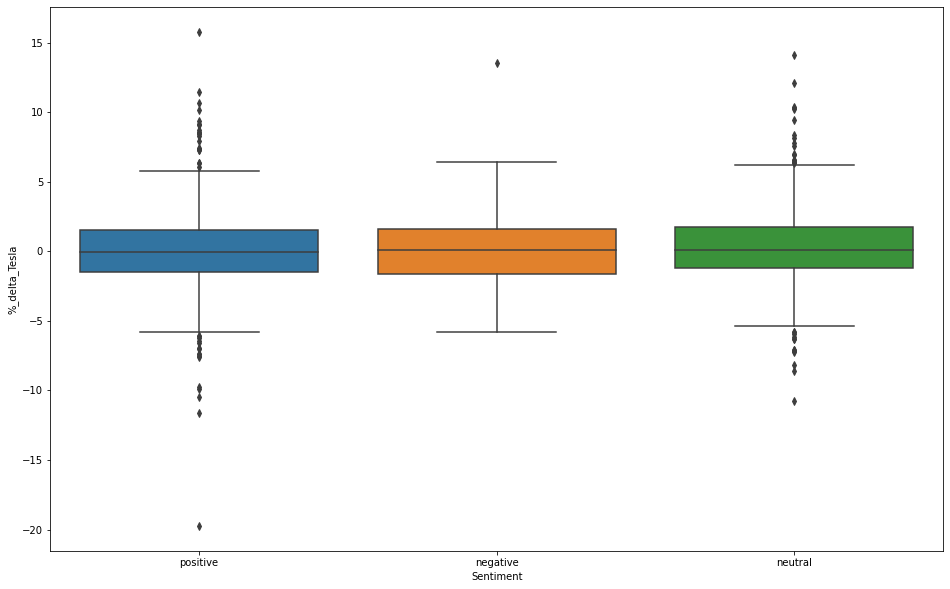

In [10]:
plt.figure(figsize=(16, 10))
sns.violinplot(x= "Sentiment", y= "%_delta_Tesla" , data=df)

plt.figure(figsize=(16, 10))
sns.boxplot(x= "Sentiment", y = "%_delta_Tesla", data=df)

### Paring sentiment against the Tesla stock price change, including the time factor

<AxesSubplot:xlabel='Time', ylabel='%_delta_Tesla'>

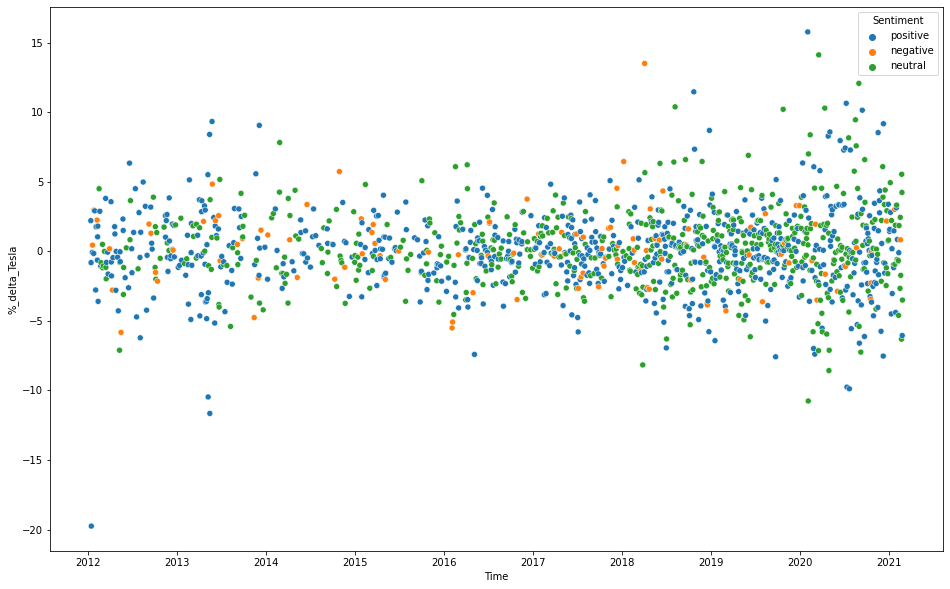

In [11]:
plt.figure(figsize=(16, 10))
sns.scatterplot(x = df['Time'], y = df['%_delta_Tesla'], 
                data = df, hue = df['Sentiment'])

### Descriptive statistics

In [12]:
df.describe()

,negative,neutral,positive,%_delta_Tesla,%_delta_Nasdaq,EMA_10
count,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000
mean,0.080435,0.412319,0.507246,0.112293,0.037466,0.114164
std,0.272064,0.492430,0.500129,2.877329,0.939924,0.815646
min,0.000000,0.000000,0.000000,-19.753521,-6.602975,-3.709668
25%,0.000000,0.000000,0.000000,-1.380618,-0.373702,-0.340090
50%,0.000000,0.000000,1.000000,0.051622,0.086436,0.170428
75%,0.000000,1.000000,1.000000,1.648076,0.504430,0.635551
max,1.000000,1.000000,1.000000,15.780249,4.738042,3.763714


### Correlations

In [13]:
df.corr()

,negative,neutral,positive,%_delta_Tesla,%_delta_Nasdaq,EMA_10
negative,1.000000,-0.247729,-0.300072,0.000719,-0.027387,-0.002802
neutral,-0.247729,1.000000,-0.849846,0.036207,0.012499,0.049085
positive,-0.300072,-0.849846,1.000000,-0.036041,0.002592,-0.046805
%_delta_Tesla,0.000719,0.036207,-0.036041,1.000000,0.421532,0.578980
%_delta_Nasdaq,-0.027387,0.012499,0.002592,0.421532,1.000000,0.225647
EMA_10,-0.002802,0.049085,-0.046805,0.578980,0.225647,1.000000


# First model

### Modelling the full data set with linear regression with neutral tweet sentiment as a baseline

In [14]:
X,y = linear_regression_data()
X = sm.add_constant(X)
lm = sm.OLS(y,X)
lm = lm.fit()
lm.summary()

C:\Users\rrusa\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          %_delta_Tesla   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     253.6
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          2.83e-163
Time:                        18:54:17   Log-Likelihood:                -3034.8
No. Observations:                1380   AIC:                             6080.
Df Residuals:                    1375   BIC:                             6106.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1027      0.092     -1.111      0.267      -0.284       0.079
negative           0.0773      0.227      0.341      0.733      -0.368       0.522
positive          -0.0622      0.124     -0.503      0.615      -0.305       0.180
%_delta_Nasdaq     0.9393      0.064     14.607      0.000       0.813       1.065
EMA_10             1.7965      0.074     24.222      0.000       1.651       1.942
==============================================================================
Omnibus:                      115.819   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              633.107
Skew:                           0.125   Prob(JB):                    3.33e-138
Kurtosis:                       6.309   Cond. No.                         4.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Checking for the fit of the model based on the full data set

C:\Users\rrusa\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


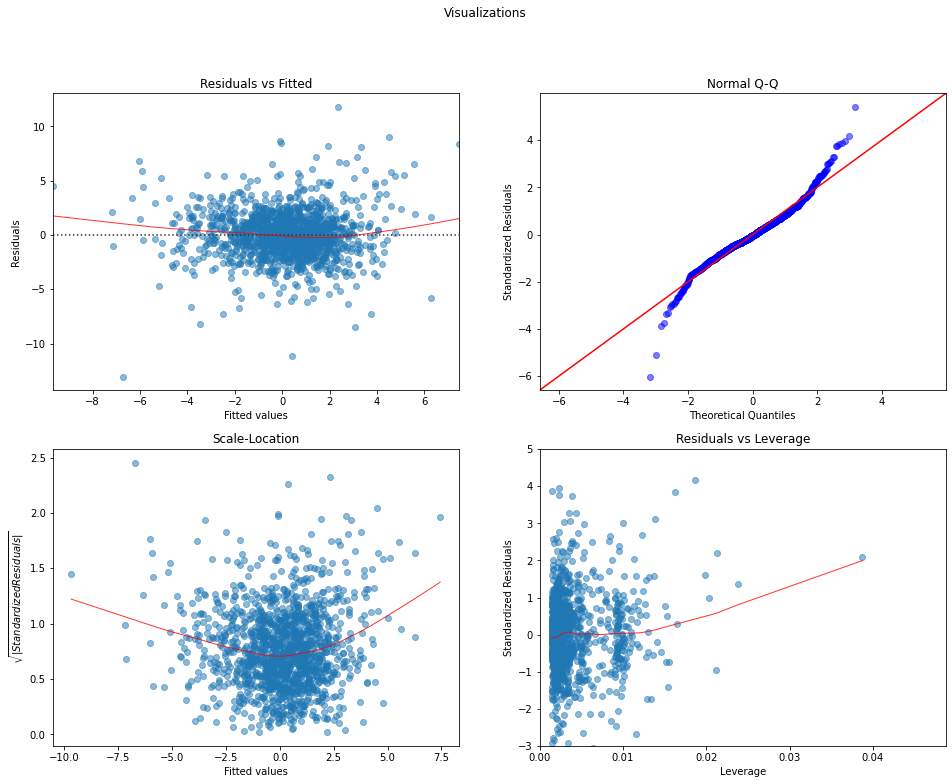

<Figure size 1152x864 with 0 Axes>

In [15]:
plt.rc("figure", figsize=(16, 12))
summary_plots(lm, title="Visualizations")

# Second model

### Eliminating outliers for the target variable

In [16]:
Quantile_10 = df['%_delta_Tesla'].quantile(0.10)
Quantile_90 = df['%_delta_Tesla'].quantile(0.90)
df = df[(df['%_delta_Tesla'] >= Quantile_10) & (df['%_delta_Tesla'] <= Quantile_90)]

### Describing the target variable without outliers

In [17]:
df['%_delta_Tesla'].describe()

count    1104.000000
mean        0.069054
std         1.525516
min        -3.119680
25%        -1.008965
50%         0.051622
75%         1.189952
max         3.233378
Name: %_delta_Tesla, dtype: float64

### Modelling the filtered data set with linear regression with neutral tweet sentiment as a baseline

In [18]:
X,y = linear_regression_data()
X = sm.add_constant(X)
lm = sm.OLS(y,X)
lm = lm.fit()
lm.summary()

C:\Users\rrusa\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          %_delta_Tesla   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     82.17
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           4.65e-61
Time:                        18:54:19   Log-Likelihood:                -1887.8
No. Observations:                1104   AIC:                             3786.
Df Residuals:                    1099   BIC:                             3811.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0799      0.063     -1.265      0.206      -0.204       0.044
negative           0.0496      0.155      0.321      0.748      -0.254       0.353
positive           0.0399      0.085      0.471      0.638      -0.126       0.206
%_delta_Nasdaq     0.4824      0.051      9.497      0.000       0.383       0.582
EMA_10             0.8364      0.058     14.351      0.000       0.722       0.951
==============================================================================
Omnibus:                       10.533   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                7.333
Skew:                           0.053   Prob(JB):                       0.0256
Kurtosis:                       2.615   Cond. No.                         4.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Checking for the fit of the model based on the filtered data set

C:\Users\rrusa\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


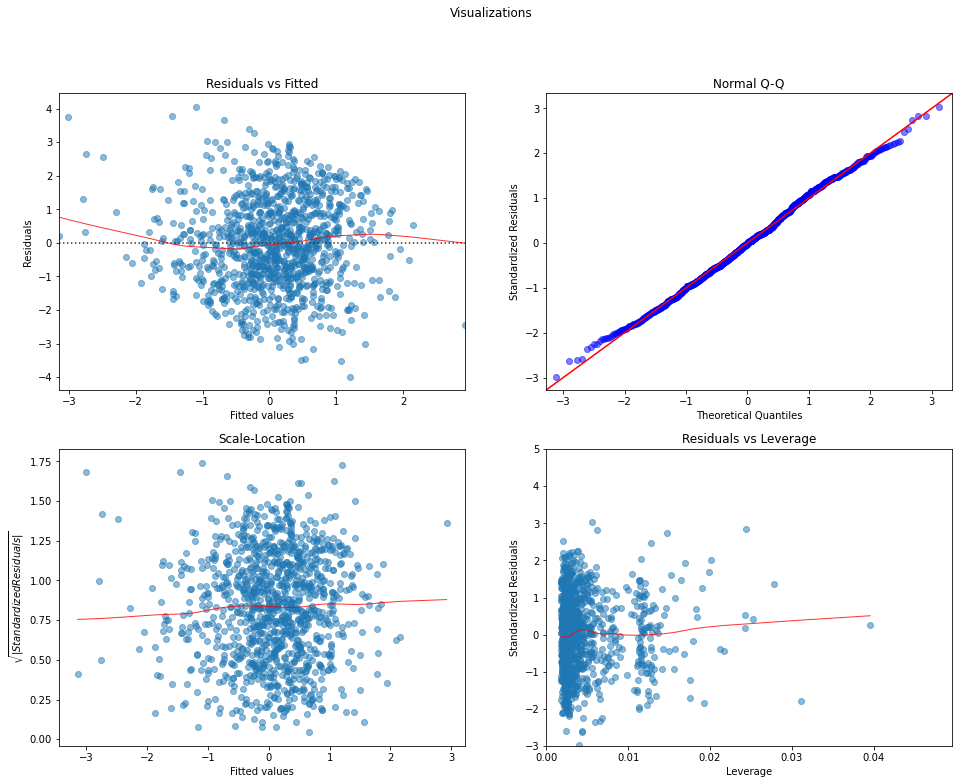

<Figure size 1152x864 with 0 Axes>

In [19]:
plt.rc("figure", figsize=(16, 12))
summary_plots(lm, title="Visualizations")

# Third model

### Turning the problem into a classification task

In [20]:
df['Binary_delta_Tesla'] = np.where(df['%_delta_Tesla'] >= 0, 1, 0)

### Modelling the filtered data set with logisic regression with neutral tweet sentiment as a baseline

In [21]:
X,y = logistic_regression_data()
X = sm.add_constant(X)
lm = sm.Logit(y,X)
lm = lm.fit()
lm.summary()

Optimization terminated successfully.
         Current function value: 0.604988
         Iterations 5


C:\Users\rrusa\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Binary_delta_Tesla   No. Observations:                 1104
Model:                          Logit   Df Residuals:                     1099
Method:                           MLE   Df Model:                            4
Date:                Tue, 14 Dec 2021   Pseudo R-squ.:                  0.1269
Time:                        18:54:20   Log-Likelihood:                -667.91
converged:                       True   LL-Null:                       -765.02
Covariance Type:            nonrobust   LLR p-value:                 6.579e-41
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1662      0.104     -1.600      0.110      -0.370       0.037
negative           0.0953      0.252      0.378      0.705      -0.398       0.589
positive           0.0265      0.138      0.192      0.848      -0.244       0.297
%_delta_Nasdaq     0.6351      0.094      6.751      0.000       0.451       0.819
EMA_10             1.1567      0.112     10.374      0.000       0.938       1.375
==================================================================================
"""

# Final remarks

### Discussion around model results
#### - With regard to R-squared/Pseudo R-squared values, we favour the first model with 42.5% of explained variance.
#### - Having removed outliers from the data set, we observed a drastic fall (lessening by half) in R-squared values; this might imply that those observations carried a significant meaning to the problem discussed
#### - Trying to reframe the task into a classification problem, we witnessed an even smaller percentage of varianced explained by the logistic model, stregthening our initial thesis than linear regression might be a better tool to describe this relationship

### As regards the real world usage, all three models can serve descriptive purposes only; hence, they should not be used as a predictive tool, since:
#### - They do not feature a training/test split -> Potential for introducing machine learning/deep learning techniques to enhence the depth of the analysis and predictive applications
#### - They lack thorougher time series analysis -> Besides checking for key elements of the time series (e.g., stationarity), we are optimistic about implementing more advanced models suitable for this kind of data, namely long short-term memory (LSTM) architecture
#### - They do not entail other potentially meaningful variables -> Since initial results of our model paint a rather blant picture as for the signs of cooefficients and their p-values, more nuances approach towards Elon Musk's tweets sentiment and their impact on Tesla stock price might improve the results. As for the first steps, we would use both current and deferred variables.
#### - They are not linked to a real time data source -> To mitigate this, we would link the model to data sourced from Twitter's API (we had unfortunately problems accessing) and the Yahoo library